In [1]:
%matplotlib inline
import psycopg2
import urllib.parse as urlparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
import requests
import re
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.base import TransformerMixin
from sklearn.learning_curve import learning_curve
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC, LinearSVC

In [2]:
check_best_params = True

# Connecting to the database

In [3]:
postgres_url = "" # Hidden

url = urlparse.urlparse(postgres_url)
dbname = url.path[1:]
user = url.username
password = url.password
host = url.hostname
port = url.port
psql = psycopg2.connect(
            dbname=dbname,
            user=user,
            password=password,
            host=host,
            port=port,
            sslmode='require'
            )
cursor = psql.cursor()

# Loading tables

In [4]:
cursor.execute("SELECT message, reason, suggestion FROM datasets_rejected")
raw_reject = cursor.fetchall()


cursor.execute("SELECT message, suggestion FROM datasets_approved")
raw_approved = cursor.fetchall()

# Helpers

In [5]:
def get_data(approved=True, detail=False, clean=True):
    """Get Data
    returns a numpy array of dicts containing spotteds as specified

    approved: approved or rejected spotteds
    detail: wether or not to return the detailed reject reason
    """

    if approved:
        data = raw_approved
    else:
        data = raw_reject

    if approved:
        return pd.DataFrame([[x[0], "aprovado", x[1]] for x in data], columns=['message', "reason", "suggestion"])
    else:
        rejected = pd.DataFrame([[x[0], x[1], x[2]] for x in data], columns=['message', "reason", "suggestion"])
        if clean:
            rejected = clean_details(rejected)
        if detail:
            return rejected
        return rejected.replace({'reason': {'^(.*?)$': 'rejeitado'}}, regex=True)


def clean_details(df):
    """Clean Details
    merges and removes unwanted columns
    """
    details_rej = [
        ("Ofensivo", ["Ofensivo ou Ódio", "Bullying individual"]),
        ("Spam", ["Corrente ou spam", "Conteúdo comercial", "Spam / Propaganda"]),
        ("Obsceno", ["Obsceno ou Assédio"]),
        ("Assédio", [False]),
        ("Off-topic", [False]),
        ("Depressivo", [False])
    ]
    res = pd.DataFrame()
    for t in details_rej:
        for c in t[1]:
            if t[0]:
                df = df.replace({'reason': {c: t[0]}})
        res = res.append(df[df['reason'] == t[0]], ignore_index=True)
    return res


def rand_reindex(arr):
    """Random reindex
    randomly reindexes an array
    """

    return arr.reindex(np.random.permutation(arr.index))


def merge_data(approved, rejected, ratio=1):
    """Merge data
    merges approved and rejected arrays using a ratio to size the approved ones
    also reindexes them
    """

    approved = rand_reindex(approved)
    approved = approved.iloc[:(round(len(rejected) * ratio))]
    return rand_reindex(approved.append(rejected, ignore_index=True))


def stop_words():
    response = requests.get("https://gist.githubusercontent.com/alopes/5358189/raw/2107d809cca6b83ce3d8e04dbd9463283025284f/stopwords.txt")
    return response.text.split()

In [6]:
rejected = get_data(False)
rejected_detail = get_data(False, True)
rejected_detail_uncleaned = get_data(False, True, False)
approved = get_data()
stopwords = stop_words()

# The dataset in numbers

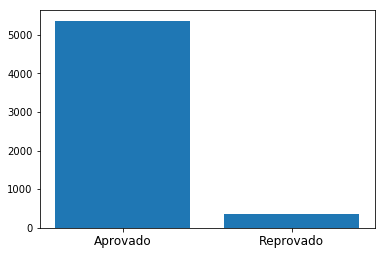

In [7]:
plt.bar(range(2), [len(approved), len(rejected)], align='center')
plt.xticks(range(2), ["Aprovado", "Reprovado"], size='large')
plt.show()

In [8]:
reject_options = set(rejected_detail['reason'])
reject_numbers = [(x, len(rejected_detail[rejected_detail.reason.isin([x])])) for x in reject_options]

reject_options1 = set(rejected_detail_uncleaned['reason'])
reject_numbers1 = [(x, len(rejected_detail_uncleaned[rejected_detail_uncleaned.reason.isin([x])])) for x in reject_options1]

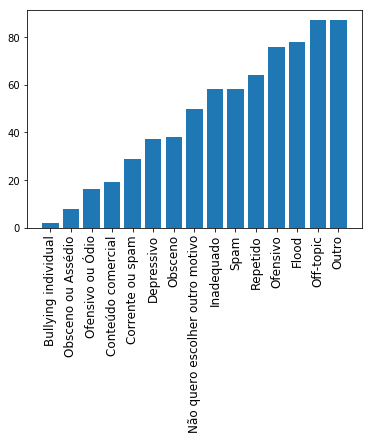

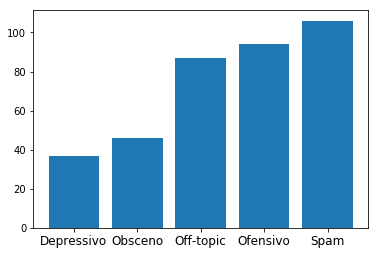

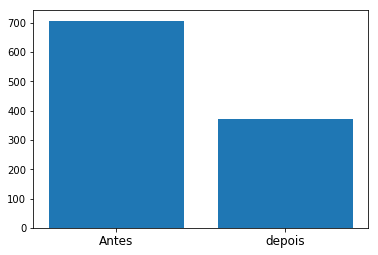

In [9]:
plt.bar(range(len(reject_numbers1)), [x[1] for x in sorted(reject_numbers1, key=lambda x: x[1])], align='center')
plt.xticks(range(len(reject_numbers1)), [x[0] for x in sorted(reject_numbers1, key=lambda x: x[1])], size='large', rotation=90)
plt.show()
plt.bar(range(len(reject_numbers)), [x[1] for x in sorted(reject_numbers, key=lambda x: x[1])], align='center')
plt.xticks(range(len(reject_numbers)), [x[0] for x in sorted(reject_numbers, key=lambda x: x[1])], size='large', rotation=0)
plt.show()

plt.bar(range(2), [len(rejected_detail_uncleaned), len(rejected_detail)], align='center')
plt.xticks(range(2), ["Antes", "depois"], size='large', rotation=0)
plt.show()

In [10]:
print(rejected_detail.groupby('reason').describe())

                                                             message  \
reason                                                                 
Depressivo count                                                  37   
           unique                                                 37   
           top     Você é um óleo\r\nPreto e podre\r\nQue impregn...   
           freq                                                    1   
Obsceno    count                                                  46   
           unique                                                 45   
           top     Moço hetero, da informática,  32 anos, 182 cm,...   
           freq                                                    2   
Ofensivo   count                                                  94   
           unique                                                 92   
           top     Eu pensei muito antes de mandar esse spotted, ...   
           freq                                                 

# More numbers

lets take a look at the top messages' lengths

In [11]:
spotteds = merge_data(approved, rejected, 100)
spotteds['length'] = spotteds['message'].map(lambda text: len(text))
print(spotteds.sort_values(by='length', ascending=0).head())

                                                message    reason  \
3338  Muitos duvidam da existência do amor. Muitos a...  aprovado   
3570  Para q mulher mais sensacional que conheci \r\...  aprovado   
670   De JTR pra uma pessoa especial\r\nNão vou dize...  aprovado   
4294  Acho que muitos spotteds aqui tem o mesmo moti...  aprovado   
504   Não sou dono de nenhuma verdade e passo bem lo...  aprovado   

           suggestion  length  
3338                     4185  
3570  Rejeitar: Outro    3786  
670                      3749  
4294                     3573  
504                      3558  


### What is this super long message?

In [12]:
print(spotteds.sort_values(by='length', ascending=0).iloc[0]['message'])

Muitos duvidam da existência do amor. Muitos afirmam ser ele uma invenção da literatura. Outros, que se trata de uma projeção neurótica imaginária. Uma patologia da família das manias. Há quem suspeite de que seja uma doença da alma. Estão errados. 

Quem conhece o amor sabe que ele habita entre nós. E sua presença nos faz sentir vivos. Por isso, o ressentimento é cego ao amor. Pode ser raro, randômico, frágil muitas vezes, mas nem por isso menos marcante quando percebido. 

Este é o tema do filme sueco "Um Homem Chamado Ove", de Hannes Holm, que foi indicado para melhor filme estrangeiro no Oscar deste ano. O cinema escandinavo está sempre entre os melhores do mundo. Poucos lidam com temas do afeto de forma tão elegante, do desespero à beleza, mas sempre elegante. 

A história é um clássico: a morte de uma esposa amada e a solidão decorrente. O filme narra a "cura" do homem chamado Ove, principalmente, pelas mãos de sua vizinha grávida iraniana, e suas filhas, além de todos os vizinho

### What is the difference in approved and rejected?

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11e3e4080>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11e875c88>], dtype=object)

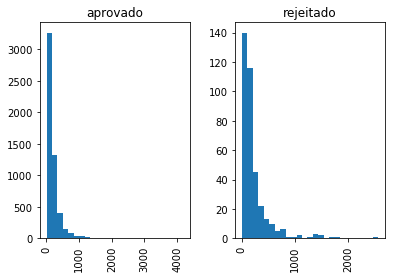

In [13]:
spotteds.hist(column='length', by='reason', bins=25)

### What else can we learn about them?

In [14]:
spotteds.groupby('reason').describe()

length
reason                      
aprovado  count  5359.000000
          mean    207.607016
          std     256.974866
          min       1.000000
          25%      81.000000
          50%     137.000000
          75%     233.000000
          max    4185.000000
rejeitado count   370.000000
          mean    220.524324
          std     287.078822
          min       1.000000
          25%      75.000000
          50%     125.000000
          75%     235.750000
          max    2562.000000

Evaluating the reject probability by message length alone is not going to be possible, then, since they are very similar

So let's try something else

# Spotteds to Vectors

Here we'll create a bag of words containing all words and n-grams present on the spotteds.

In [15]:
spotteds = merge_data(approved, rejected, 1)

# First we initialize the vectorizer
count_vectorizer = CountVectorizer(strip_accents='ascii', analyzer='word', stop_words=stopwords, ngram_range=(1, 3))

# Then we fit and transform it to create our bag of words
count_transformer = count_vectorizer.fit(spotteds['message'])
bag_o_words = count_transformer.transform(spotteds['message'])

print(bag_o_words.shape)

(740, 35003)


### Normalizing our bag

In order for us to get better results, its a good idea to normalize and do some term weighting using sklearn's TF-IDF methods

In [16]:
tfidf_transformer = TfidfTransformer().fit(bag_o_words)

norm_bag_o_words = tfidf_transformer.transform(bag_o_words)

print(norm_bag_o_words.shape)

(740, 35003)


# Training our model

now that we extracted our features it's time to create and train our model to predict stuff

We'll use Naive Bayes for now, but later we'll experiment with some other classification algorithms

In [17]:
%time approve_predictor = MultinomialNB().fit(norm_bag_o_words, spotteds['reason'])

CPU times: user 4.99 ms, sys: 1.78 ms, total: 6.77 ms
Wall time: 5.77 ms


Let's classify some random messages

In [18]:
spotted_number = 5
single_spotted = tfidf_transformer.transform(count_transformer.transform([spotteds.iloc[spotted_number]['message']]))
print(spotteds.iloc[spotted_number]['message'])
print('predicted:', approve_predictor.predict(single_spotted)[0])
print('expected:', spotteds.iloc[spotted_number]['reason'])

Civil e Fea, da bom?
predicted: rejeitado
expected: rejeitado


Success!

Now let's generate predictions for all spotteds

In [19]:
all_predictions = approve_predictor.predict(norm_bag_o_words)
print(all_predictions)

['aprovado' 'rejeitado' 'rejeitado' 'rejeitado' 'aprovado' 'rejeitado'
 'rejeitado' 'rejeitado' 'aprovado' 'aprovado' 'aprovado' 'aprovado'
 'rejeitado' 'rejeitado' 'aprovado' 'rejeitado' 'rejeitado' 'aprovado'
 'rejeitado' 'aprovado' 'rejeitado' 'aprovado' 'rejeitado' 'aprovado'
 'rejeitado' 'aprovado' 'rejeitado' 'rejeitado' 'rejeitado' 'rejeitado'
 'aprovado' 'aprovado' 'rejeitado' 'rejeitado' 'rejeitado' 'rejeitado'
 'aprovado' 'aprovado' 'aprovado' 'aprovado' 'aprovado' 'rejeitado'
 'aprovado' 'rejeitado' 'aprovado' 'aprovado' 'rejeitado' 'rejeitado'
 'rejeitado' 'rejeitado' 'rejeitado' 'rejeitado' 'rejeitado' 'aprovado'
 'rejeitado' 'rejeitado' 'aprovado' 'rejeitado' 'aprovado' 'aprovado'
 'rejeitado' 'aprovado' 'aprovado' 'aprovado' 'aprovado' 'aprovado'
 'rejeitado' 'rejeitado' 'rejeitado' 'rejeitado' 'aprovado' 'aprovado'
 'rejeitado' 'rejeitado' 'aprovado' 'aprovado' 'rejeitado' 'aprovado'
 'aprovado' 'aprovado' 'rejeitado' 'rejeitado' 'aprovado' 'rejeitado'
 'aprovado' 'reje

Let's evaluate it a little bit

accuracy 0.994594594595
confusion matrix
 [[369   1]
 [  3 367]]



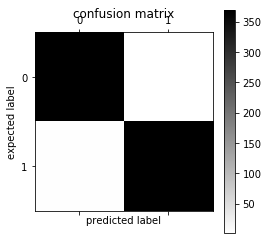

In [20]:
print('accuracy', accuracy_score(spotteds['reason'], all_predictions))
print('confusion matrix\n', confusion_matrix(spotteds['reason'], all_predictions))
print()
plt.matshow(confusion_matrix(spotteds['reason'], all_predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [21]:
print(classification_report(spotteds['reason'], all_predictions))

             precision    recall  f1-score   support

   aprovado       0.99      1.00      0.99       370
  rejeitado       1.00      0.99      0.99       370

avg / total       0.99      0.99      0.99       740



# Testing our model

Now that we have our model ready, let's test it a little bit

First we create training and testing sets

In [22]:
msg_train, msg_test, label_train, label_test = train_test_split(spotteds['message'], spotteds['reason'], test_size=0.2)

Then we recap our pipeline

In [23]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(strip_accents='ascii', analyzer='word', stop_words=stopwords, ngram_range=(1, 3))),
    ('tfidf', TfidfTransformer(use_idf=False)),
    ('classifier', MultinomialNB()),
])

Then we test it

In [24]:
scores = cross_val_score(pipeline,
                         msg_train,
                         label_train,
                         cv=10,
                         scoring='accuracy',
                         n_jobs=-1,
                         )
print(scores)
print()
print(scores.mean(), scores.std())

[ 0.7         0.65        0.61016949  0.69491525  0.77966102  0.74576271
  0.66101695  0.69491525  0.62711864  0.69491525]

0.685847457627 0.0489035922295


Meh. A little more than average modeling, but that may be due to the fact that our data contains a lot of garbage and can be further cleaned.

Another nice thing that we can do is generate some learning curves to see how our model changes over time

In [25]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

CPU times: user 222 ms, sys: 49.2 ms, total: 271 ms
Wall time: 923 ms


<module 'matplotlib.pyplot' from '/Users/Maronato/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py'>

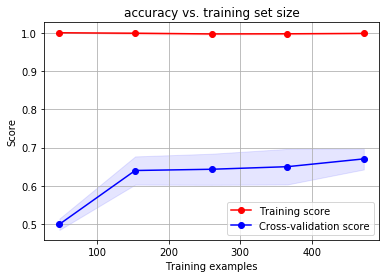

In [26]:
%time plot_learning_curve(pipeline, "accuracy vs. training set size", msg_train, label_train, cv=5)

This shows us that we still have a lot to fix in our dataset, but the more data we collect, the better our predictions may become.

But what if our pipeline is not ideal? We can evaluate it by doing a grid search on various possible parameters.

The code below will try every permutation of pipeline parameter available and print the best performing one

In [27]:
params = {
    'tfidf__use_idf': (True, False),
    'vectorizer__analyzer': ('word', 'char', 'char_wb'),
    'vectorizer__stop_words': (stopwords, None),
    'vectorizer__ngram_range': ((1, 1), (1, 2), (1, 3)),
    'vectorizer__strip_accents': ('ascii', 'unicode', None),
}

grid = GridSearchCV(
    pipeline,  # pipeline from above
    params,  # parameters to tune via cross validation
    refit=True,  # fit using all available data at the end, on the best found param combination
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(label_train, n_folds=5),  # what type of cross validation to use
)

if check_best_params:
    %time nb_detector = grid.fit(msg_train, label_train)
    print(max(nb_detector.grid_scores_, key=lambda x:x[1]))
else:
    print("Skipped")

CPU times: user 2.45 s, sys: 120 ms, total: 2.57 s
Wall time: 25.9 s
mean: 0.69595, std: 0.04344, params: {'vectorizer__ngram_range': (1, 3), 'vectorizer__analyzer': 'char', 'vectorizer__strip_accents': None, 'vectorizer__stop_words': ['de', 'a', 'o', 'que', 'e', 'do', 'da', 'em', 'um', 'para', 'é', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'foi', 'ao', 'ele', 'das', 'tem', 'à', 'seu', 'sua', 'ou', 'ser', 'quando', 'muito', 'há', 'nos', 'já', 'está', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'era', 'depois', 'sem', 'mesmo', 'aos', 'ter', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'estão', 'você', 'tinha', 'foram', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'têm', 'numa', 'pelos', 'elas', 'havia', 'seja', 'qual', 'será', 'nós', 'tenho', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'fosse', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 

Remeber, tho, that here we are only predicting if a spotted is to be approved or rejected.

We also have data to predict *why* said spotted will be rejected, so let us put that to use

# Predicting Reasons

predicting reasons should be very straightfoward and a lot of our previous code can be reused

We start by creating another bag of words

In [28]:
# Since we are not using dataframes we need to create a list of words
rejected_detail = rand_reindex(rejected_detail)

# Then we fit and transform it to create our bag of words
rej_count_transformer = count_vectorizer.fit(rejected_detail['message'])
rej_bag_o_words = count_transformer.transform(rejected_detail['message'])

print(rej_bag_o_words.shape)

(370, 18539)


In [29]:
rej_tfidf_transformer = TfidfTransformer().fit(rej_bag_o_words)

rej_norm_bag_o_words = rej_tfidf_transformer.transform(rej_bag_o_words)

print(rej_norm_bag_o_words.shape)

(370, 18539)


In [30]:
%time reason_predictor = MultinomialNB().fit(rej_norm_bag_o_words, rejected_detail['reason'])

CPU times: user 4.37 ms, sys: 1.81 ms, total: 6.18 ms
Wall time: 5.35 ms


In [31]:
rej_predictions = reason_predictor.predict(rej_norm_bag_o_words)
print(rej_predictions[:10])

['Obsceno' 'Spam' 'Off-topic' 'Spam' 'Off-topic' 'Ofensivo' 'Off-topic'
 'Spam' 'Spam' 'Ofensivo']


accuracy 0.940540540541
confusion matrix
 [[ 21   0   2   0  14]
 [  0  40   2   0   4]
 [  0   0  94   0   0]
 [  0   0   0  87   0]
 [  0   0   0   0 106]]



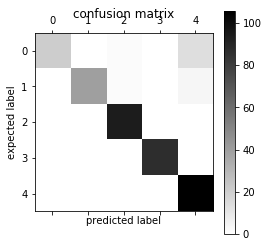

In [32]:
print('accuracy', accuracy_score(rejected_detail['reason'], rej_predictions))
print('confusion matrix\n', confusion_matrix(rejected_detail['reason'], rej_predictions))
print()
plt.matshow(confusion_matrix(rejected_detail['reason'], rej_predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [33]:
print(classification_report(rejected_detail['reason'], rej_predictions))

             precision    recall  f1-score   support

 Depressivo       1.00      0.57      0.72        37
    Obsceno       1.00      0.87      0.93        46
   Ofensivo       0.96      1.00      0.98        94
  Off-topic       1.00      1.00      1.00        87
       Spam       0.85      1.00      0.92       106

avg / total       0.95      0.94      0.94       370



In [34]:
msg_train, msg_test, label_train, label_test = train_test_split(rejected_detail['message'], rejected_detail['reason'], test_size=0.2)

In [35]:
scores = cross_val_score(pipeline,
                         msg_train,
                         label_train,
                         cv=10,
                         scoring='accuracy',
                         n_jobs=-1,
                         )
print(scores)
print()
print(scores.mean(), scores.std())

[ 0.46875     0.32258065  0.41935484  0.35483871  0.46666667  0.43333333
  0.48275862  0.46428571  0.48148148  0.44444444]

0.433849445445 0.0517960999893


CPU times: user 274 ms, sys: 50.2 ms, total: 324 ms
Wall time: 1.34 s


<module 'matplotlib.pyplot' from '/Users/Maronato/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py'>

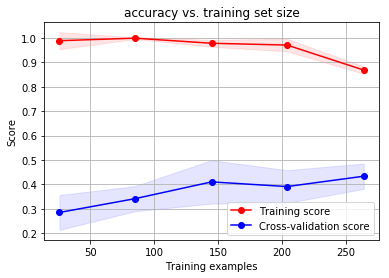

In [36]:
%time plot_learning_curve(pipeline, "accuracy vs. training set size", msg_train, label_train, cv=10)

As you can see, our prediction is pretty bad. It's a lot better than luck, anyway, and our dataset is pretty lacking.

But we can try more. Let's try

# SVMs

SVMs are another option that we can try. Let's jump to the fun part and evaluate the best possible parameters and check how they perform when compared to NB

In [37]:
# Generate new training and testing sets
msg_train, msg_test, label_train, label_test = train_test_split(spotteds['message'], spotteds['reason'], test_size=0.2)

pipeline_svm = Pipeline([
    ('vectorizer', CountVectorizer(strip_accents='ascii', lowercase=False, analyzer='word', stop_words=stopwords, ngram_range=(1, 3))),
    ('tfidf', TfidfTransformer(use_idf=False)),
    ('classifier', SVC(C=1, kernel='linear')),
])

# pipeline parameters to automatically explore and tune
param_svm = [
  {'classifier__C': [1, 10, 100, 1000], 'classifier__kernel': ['linear']},
  {'classifier__C': [1, 10, 100, 1000], 'classifier__gamma': [0.001, 0.0001], 'classifier__kernel': ['rbf']},
]

grid_svm = GridSearchCV(
    pipeline_svm,  # pipeline from above
    param_grid=param_svm,  # parameters to tune via cross validation
    refit=True,  # fit using all data, on the best detected classifier
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(label_train, n_folds=5),  # what type of cross validation to use
)


%time svm_detector = grid_svm.fit(msg_train, label_train)
print(max(svm_detector.grid_scores_, key=lambda x:x[1]))

CPU times: user 588 ms, sys: 60 ms, total: 648 ms
Wall time: 3.26 s
mean: 0.64189, std: 0.01106, params: {'classifier__kernel': 'linear', 'classifier__C': 10}


accuracy 0.641891891892
confusion matrix
 [[42 35]
 [18 53]]



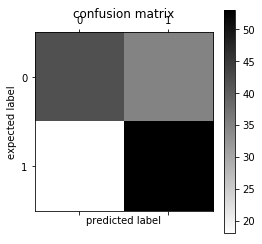

In [38]:
svm_predictions = svm_detector.predict(msg_test)
print('accuracy', accuracy_score(label_test, svm_predictions))
print('confusion matrix\n', confusion_matrix(label_test, svm_predictions))
print()
plt.matshow(confusion_matrix(label_test, svm_predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

A little better, huh?

Maybe if we combine the two together and then create multiple layers of them both, and maybe if we iteratively train vectors with other parameters and input them into our _network_

uh! uh! Maybe if we create a custom _tokenizer_ so that 'vc' and 'você' are tokenized as one! That ought to yield better results, right?

# Further analysis

Our models are rather ok, but we can make them better. Main focus of development are:

- Custom Tokenizer
- Clean dataset
- Explore other models
- Explore neural nets